DEEP REINFORCEMENT LEARNING EXPLAINED - 06
# **Solving Frozen-Lake Environment With Cross-Entropy Method**
## Agent Creation Using Deep Neural Networks

 

## The Environment

In [19]:
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [20]:
import gym
import gym.spaces

env = gym.make('FrozenLake-v0', is_slippery=False)

In [21]:
class OneHotWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(OneHotWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(0.0, 1.0, (env.observation_space.n, ), dtype=np.float32)

    def observation(self, observation):
        r = np.copy(self.observation_space.low)
        r[observation] = 1.0
        return r

env = OneHotWrapper(env)

## The Agent
 ### The Model

In [22]:
obs_size = env.observation_space.shape[0] # 16
n_actions = env.action_space.n  # 4
HIDDEN_SIZE = 32


net= nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.Sigmoid(),
            nn.Linear(HIDDEN_SIZE, n_actions)
        )

### Get an Action

In [23]:
sm = nn.Softmax(dim=1)

def select_action(state):
        state_t = torch.FloatTensor([state])
        act_probs_t = sm(net(state_t))
        act_probs = act_probs_t.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        return action

### Optimizer and Loss function

In [24]:
import torch.optim as optim

objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

## Training the Agent

In [25]:
BATCH_SIZE = 100

GAMMA = 0.9

PERCENTILE = 30
REWARD_GOAL = 0.8

from collections import namedtuple

Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])


In [26]:
def graph_rewards(rewards_mean):
    f, sp = plt.subplots()
    sp.plot(rewards_mean, 'b', label='Average rewards of batch')
    sp.legend()
    sp.set(xlabel='num episodes', ylabel='ave reward',
           title='Average Batch Rewards')
    
    sp.grid()
    plt.show()

In [27]:
iter_no = 0
reward_mean = 0
full_batch = []
batch = []
episode_steps = []
episode_reward = 0.0
state = env.reset()
mean_rewards = []

while reward_mean < REWARD_GOAL:
        action = select_action(state)
        next_state, reward, episode_is_done, _ = env.step(action)

        episode_steps.append(EpisodeStep(observation=state, action=action))
        episode_reward += reward
        
        if episode_is_done: # Episode finished            
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            next_state = env.reset()
            episode_steps = []
            episode_reward = 0.0
             
            if len(batch) == BATCH_SIZE: # New set of batches ready --> select "elite"
                reward_mean = float(np.mean(list(map(lambda s: s.reward, batch))))
                elite_candidates= batch 
                returnG = list(map(lambda s: s.reward * (GAMMA ** len(s.steps)), elite_candidates))
                reward_bound = np.percentile(returnG, PERCENTILE)

                train_obs = []
                train_act = []
                elite_batch = []
                for example, discounted_reward in zip(elite_candidates, returnG):
                        if discounted_reward > reward_bound:
                              train_obs.extend(map(lambda step: step.observation, example.steps))
                              train_act.extend(map(lambda step: step.action, example.steps))
                              elite_batch.append(example)
                full_batch=elite_batch
                state=train_obs
                acts=train_act

                
                if len(full_batch) != 0 : # just in case empty during an iteration
                 state_t = torch.FloatTensor(state)
                 acts_t = torch.LongTensor(acts)
                 optimizer.zero_grad()
                 action_scores_t = net(state_t)
                 loss_t = objective(action_scores_t, acts_t)
                 loss_t.backward()
                 optimizer.step()
                 mean_rewards.append(reward_mean)
                 print("%d: loss=%.3f, reward_mean=%.3f \r" % (iter_no, loss_t.item(), reward_mean))
                 iter_no += 1
                batch = []
        state = next_state



0: loss=1.328, reward_mean=0.010 
1: loss=1.376, reward_mean=0.030 
2: loss=1.324, reward_mean=0.060 
3: loss=1.322, reward_mean=0.020 
4: loss=1.302, reward_mean=0.010 
5: loss=1.298, reward_mean=0.030 
6: loss=1.325, reward_mean=0.020 
7: loss=1.352, reward_mean=0.030 
8: loss=1.259, reward_mean=0.030 
9: loss=1.289, reward_mean=0.020 
10: loss=1.137, reward_mean=0.010 
11: loss=1.288, reward_mean=0.020 
12: loss=1.268, reward_mean=0.070 
13: loss=1.255, reward_mean=0.080 
14: loss=1.241, reward_mean=0.040 
15: loss=1.187, reward_mean=0.020 
16: loss=1.262, reward_mean=0.070 
17: loss=1.280, reward_mean=0.040 
18: loss=1.276, reward_mean=0.020 
19: loss=1.213, reward_mean=0.070 
20: loss=1.191, reward_mean=0.050 
21: loss=1.282, reward_mean=0.070 
22: loss=1.175, reward_mean=0.070 
23: loss=1.160, reward_mean=0.040 
24: loss=1.228, reward_mean=0.060 
25: loss=1.110, reward_mean=0.070 
26: loss=1.198, reward_mean=0.120 
27: loss=1.122, reward_mean=0.080 
28: loss=1.178, reward_mean=0.

233: loss=0.789, reward_mean=0.170 
234: loss=0.784, reward_mean=0.220 
235: loss=0.738, reward_mean=0.350 
236: loss=0.715, reward_mean=0.210 
237: loss=0.801, reward_mean=0.200 
238: loss=0.746, reward_mean=0.300 
239: loss=0.699, reward_mean=0.280 
240: loss=0.695, reward_mean=0.240 
241: loss=0.711, reward_mean=0.220 
242: loss=0.705, reward_mean=0.190 
243: loss=0.702, reward_mean=0.270 
244: loss=0.736, reward_mean=0.250 
245: loss=0.681, reward_mean=0.330 
246: loss=0.753, reward_mean=0.270 
247: loss=0.690, reward_mean=0.210 
248: loss=0.721, reward_mean=0.310 
249: loss=0.809, reward_mean=0.250 
250: loss=0.699, reward_mean=0.230 
251: loss=0.712, reward_mean=0.260 
252: loss=0.717, reward_mean=0.300 
253: loss=0.698, reward_mean=0.300 
254: loss=0.758, reward_mean=0.360 
255: loss=0.650, reward_mean=0.270 
256: loss=0.787, reward_mean=0.200 
257: loss=0.728, reward_mean=0.230 
258: loss=0.805, reward_mean=0.170 
259: loss=0.726, reward_mean=0.360 
260: loss=0.663, reward_mean

462: loss=0.591, reward_mean=0.510 
463: loss=0.565, reward_mean=0.540 
464: loss=0.564, reward_mean=0.580 
465: loss=0.581, reward_mean=0.530 
466: loss=0.546, reward_mean=0.470 
467: loss=0.595, reward_mean=0.500 
468: loss=0.613, reward_mean=0.540 
469: loss=0.592, reward_mean=0.510 
470: loss=0.547, reward_mean=0.520 
471: loss=0.559, reward_mean=0.580 
472: loss=0.584, reward_mean=0.450 
473: loss=0.576, reward_mean=0.640 
474: loss=0.543, reward_mean=0.520 
475: loss=0.566, reward_mean=0.530 
476: loss=0.592, reward_mean=0.530 
477: loss=0.550, reward_mean=0.510 
478: loss=0.574, reward_mean=0.590 
479: loss=0.593, reward_mean=0.530 
480: loss=0.555, reward_mean=0.640 
481: loss=0.588, reward_mean=0.600 
482: loss=0.528, reward_mean=0.590 
483: loss=0.567, reward_mean=0.650 
484: loss=0.562, reward_mean=0.600 
485: loss=0.546, reward_mean=0.540 
486: loss=0.540, reward_mean=0.660 
487: loss=0.591, reward_mean=0.590 
488: loss=0.603, reward_mean=0.570 
489: loss=0.545, reward_mean

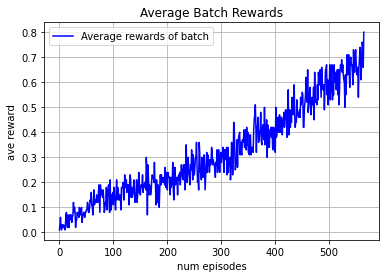

In [29]:
graph_rewards(mean_rewards)

## Test the Agent

In [15]:
test_env = OneHotWrapper(gym.make('FrozenLake-v0', is_slippery=False))
state= test_env.reset()
test_env.render()

is_done = False

while not is_done:
    action = select_action(state)
    new_state, reward, is_done, _ = test_env.step(action)
    test_env.render()
    state = new_state

print("reward = ", reward)


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
reward =  0.0


----

DEEP REINFORCEMENT LEARNING EXPLAINED - 07
# **Cross-Entropy Method Performance Analysis**
## Implementation of the Cross-Entropy Training Loop

### Base line